In [6]:
"""
LangGraph Workflow 정의
게임의 전체 흐름을 그래프로 구성
"""

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from state import GameState
from nodes import (
    setup_game_node,
    character_speak_node,
    user_input_node,
    vote_node,
    next_turn_node,
    wait_for_user_node,
    night_phase_node,
    select_next_speaker_node  # select_next_speaker_node 추가
)


def should_continue_discussion(state: GameState) -> str:
    """
    대화를 계속할지 결정하는 조건부 엣지

    로직:
    1. phase가 "end"면 종료
    2. phase가 "user_turn"이면 사용자 턴 대기
    3. phase가 "discussion"이면 AI가 계속 말하기
    4. phase가 "night"이면 밤 페이즈로 이동 (이 로직은 외부에서 phase 변경 시 작동)
    """
    phase = state.get("phase", "discussion")

    # 게임 종료
    if phase == "end":
        return "end"

    # 사용자가 투표를 했으면 투표 처리
    elif state.get("user_target"):
        return "vote"

    # 사용자 턴 (AI 턴이 끝남)
    elif phase == "user_turn":
        return "wait_user"

    # 1:1 대화 모드 (사용자 입력 대기)
    elif phase == "one_on_one":
        return "wait_user"
        
    # 밤 페이즈로 이동
    elif phase == "night":
        return "night_phase"

    # AI 토론 계속 (수동 진행을 위해 wait_user로 보냄)
    elif phase == "discussion" or phase == "free_discussion":
        return "wait_user"

    # 기본값
    else:
        return "character_speak"


def after_user_wait(state: GameState) -> str:
    """
    사용자 대기 후 다음 동작 결정

    - user_input이 들어왔으면 user_input 노드로
    - user_target이 들어왔으면 vote 노드로
    - phase가 night로 변경되었으면 night_phase 노드로
    - 아무것도 없으면 (Enter)
        - free_discussion 페이즈면 select_next_speaker (다음 화자 선정)
        - 아니면 계속 대기
    """
    if state.get("phase") == "night":
        return "night_phase"
    elif state.get("user_target"):
        return "vote"
    elif state.get("user_input"):
        return "user_input"
    elif state.get("phase") == "free_discussion":
        return "select_next_speaker"        
    else:
        # 계속 대기 (실제로는 외부에서 입력을 주입할 때까지)
        return "wait_user"


def after_user_input(state: GameState) -> str:
    """
    유저 입력 후 분기 처리
    
    - free_discussion: 다음 화자 선정 (select_next_speaker)
    - one_on_one: 현재 화자 유지 (character_speak)
    - 그 외: select_next_speaker (기본값)
    """
    phase = state.get("phase")
    
    if phase == "free_discussion":
        return "select_next_speaker"
    elif phase == "one_on_one":
        return "character_speak"
    else:
        return "select_next_speaker"


def create_game_graph():
    """
    마피아 게임 그래프 생성
    """
    # StateGraph 초기화
    workflow = StateGraph(GameState)

    # 노드 추가
    workflow.add_node("setup", setup_game_node)
    workflow.add_node("character_speak", character_speak_node)
    workflow.add_node("wait_user", wait_for_user_node)
    workflow.add_node("user_input", user_input_node)
    workflow.add_node("vote", vote_node)
    workflow.add_node("next_turn", next_turn_node)
    workflow.add_node("night_phase", night_phase_node)
    workflow.add_node("select_next_speaker", select_next_speaker_node) # 노드 추가

    # 시작점: setup
    workflow.set_entry_point("setup")

    # setup 후 바로 wait_user로 (사용자 명령 대기)
    workflow.add_edge("setup", "wait_user")

    # select_next_speaker 후 character_speak
    workflow.add_edge("select_next_speaker", "character_speak")

    # character_speak 후 next_turn (discussion 모드에서는 next_turn이 사실상 wait_user로 가는 역할만 하거나 무시됨)
    # 하지만 기존 로직 유지를 위해 next_turn을 거치게 하되, next_turn의 역할을 축소했음.
    # discussion 모드에서는 next_turn -> should_continue_discussion -> wait_user로 감
    workflow.add_edge("character_speak", "next_turn")
    
    # night_phase 후 wait_user
    workflow.add_edge("night_phase", "wait_user")

    # next_turn 후 조건부 분기
    workflow.add_conditional_edges(
        "next_turn",
        should_continue_discussion,
        {
            "character_speak": "character_speak",  # (사용 안함)
            "wait_user": "wait_user",              # discussion 모드에서는 여기로
            "vote": "vote",
            "end": END,
            "night_phase": "night_phase"
        }
    )

    # wait_user 노드에서 사용자 입력 대기
    workflow.add_conditional_edges(
        "wait_user",
        after_user_wait,
        {
            "user_input": "user_input",
            "vote": "vote",
            "wait_user": "wait_user",
            "night_phase": "night_phase",
            "select_next_speaker": "select_next_speaker", # discussion 모드 자동 진행
            "character_speak": "character_speak" # (하위 호환)
        }
    )

    # user_input 후 분기 처리 (1:1 vs 다수 논의)
    workflow.add_conditional_edges(
        "user_input",
        after_user_input,
        {
            "select_next_speaker": "select_next_speaker",
            "character_speak": "character_speak"
        }
    )

    # vote 후 종료
    workflow.add_edge("vote", END)

    # 컴파일
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)

    return app


---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	setup(setup)
	character_speak(character_speak)
	wait_user(wait_user)
	user_input(user_input)
	vote(vote)
	next_turn(next_turn)
	night_phase(night_phase)
	select_next_speaker(select_next_speaker)
	__end__([<p>__end__</p>]):::last
	__start__ --> setup;
	character_speak --> next_turn;
	next_turn -. &nbsp;end&nbsp; .-> __end__;
	next_turn -.-> character_speak;
	next_turn -.-> night_phase;
	next_turn -.-> vote;
	next_turn -.-> wait_user;
	night_phase --> wait_user;
	select_next_speaker --> character_speak;
	setup --> wait_user;
	user_input -.-> character_speak;
	user_input -.-> select_next_speaker;
	wait_user -.-> character_speak;
	wait_user -.-> night_phase;
	wait_user -.-> select_next_speaker;
	wait_user -.-> user_input;
	wait_user -.-> vote;
	vote --> __end__;
	wait_user -.-> wait_user;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



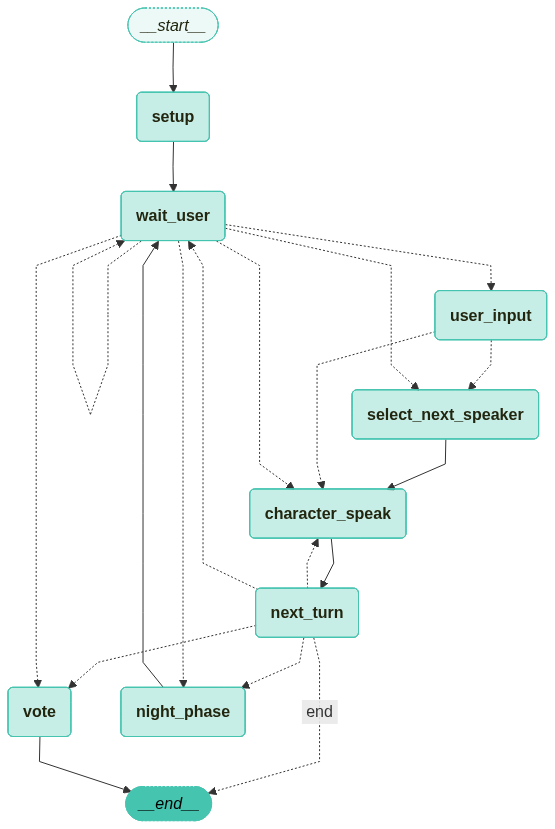

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	setup(setup)
	character_speak(character_speak)
	wait_user(wait_user)
	user_input(user_input)
	vote(vote)
	next_turn(next_turn)
	night_phase(night_phase)
	select_next_speaker(select_next_speaker)
	__end__([<p>__end__</p>]):::last
	__start__ --> setup;
	character_speak --> next_turn;
	next_turn -. &nbsp;end&nbsp; .-> __end__;
	next_turn -.-> character_speak;
	next_turn -.-> night_phase;
	next_turn -.-> vote;
	next_turn -.-> wait_user;
	night_phase --> wait_user;
	select_next_speaker --> character_speak;
	setup --> wait_user;
	user_input -.-> character_speak;
	user_input -.-> select_next_speaker;
	wait_user -.-> character_speak;
	wait_user -.-> night_phase;
	wait_user -.-> select_next_speaker;
	wait_user -.-> user_input;
	wait_user -.-> vote;
	vote --> __end__;
	wait_user -.-> wait_user;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



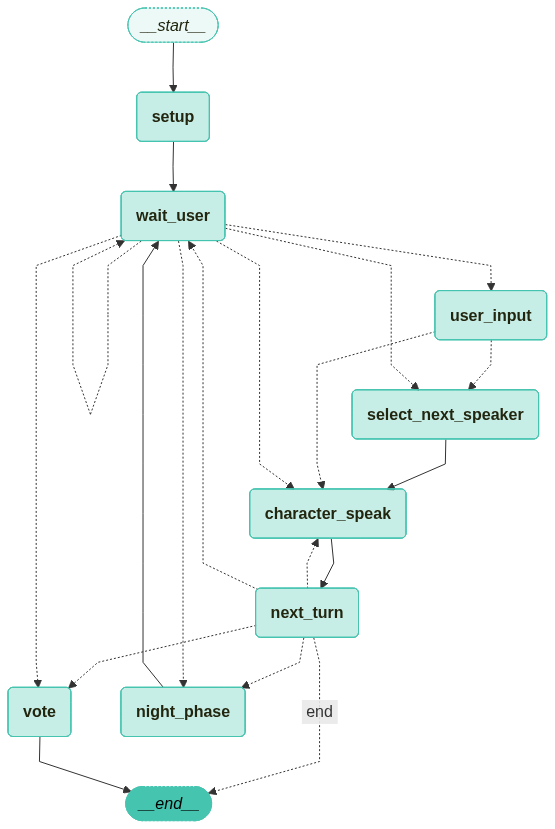

In [7]:
from langchain_teddynote.graphs import visualize_graph
# 그래프 시각화용 (선택사항)
def visualize_graph1():
    """
    그래프 구조를 시각화 (mermaid 형식)
    """
    app = create_game_graph()

    try:
        # Mermaid 다이어그램 출력
        print(app.get_graph().draw_mermaid())
        visualize_graph(app, xray=True)
        
    except Exception as e:
        print(f"시각화 실패: {e}")
        print("그래프는 정상적으로 생성되었습니다.")


if __name__ == "__main__":
    # 그래프 시각화 테스트
    visualize_graph1()

visualize_graph1()